In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dollar Cost Average vs Buy-Hold

This notebook explores the case where the investor has a fixed amount of capital and has to choose between deploying it all at once at the start of the time period vs deploying regular amounts at fixed time intervals

## Imports

In [34]:
import os
import numpy as np
# import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, laplace, gmean
from Scripts.update_data import update_daily_price_data_yahoo
from scipy.stats import gaussian_kde

## Load data

In [35]:
asset = 'SPY'
update_daily_price_data_yahoo(asset)

df = pl.read_csv(f'./Data/Daily_price_data/yahoo_finance/{asset}.csv')
df = df.with_columns(pl.col('date').str.to_date())
df

,date,open,high,low,close,adjclose,volume
i64,date,f64,f64,f64,f64,f64,i64
0,1993-01-29,43.96875,43.96875,43.75,43.9375,24.608624,1003200
1,1993-02-01,43.96875,44.25,43.96875,44.25,24.783648,480500
2,1993-02-02,44.21875,44.375,44.125,44.34375,24.836161,201300
3,1993-02-03,44.40625,44.84375,44.375,44.8125,25.098698,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.0,25.203714,531500
…,…,…,…,…,…,…,…
7973,2024-09-30,570.419983,574.380005,568.080017,573.76001,573.76001,63557400
7974,2024-10-01,573.400024,574.059998,566.0,568.619995,568.619995,72668800
7975,2024-10-02,567.710022,569.900024,565.27002,568.859985,568.859985,38097800


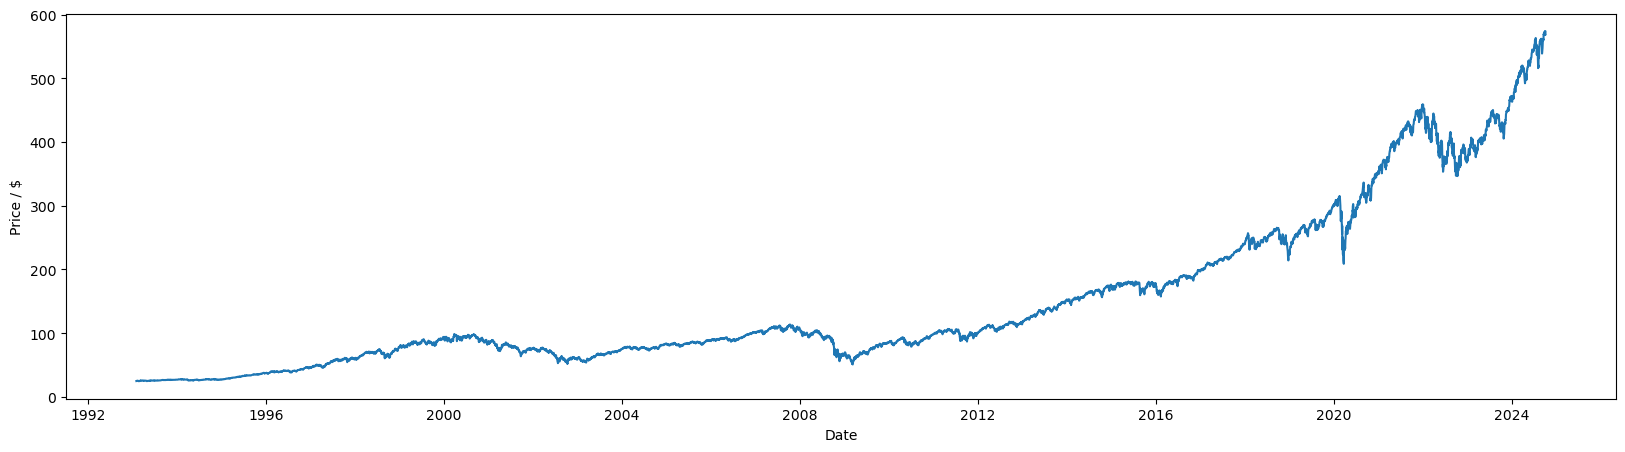

In [36]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'], df['adjclose'])
plt.xlabel('Date')
plt.ylabel('Price / $')
plt.show()

## Buy-Hold strategy

Use adjusted close to account for dividends

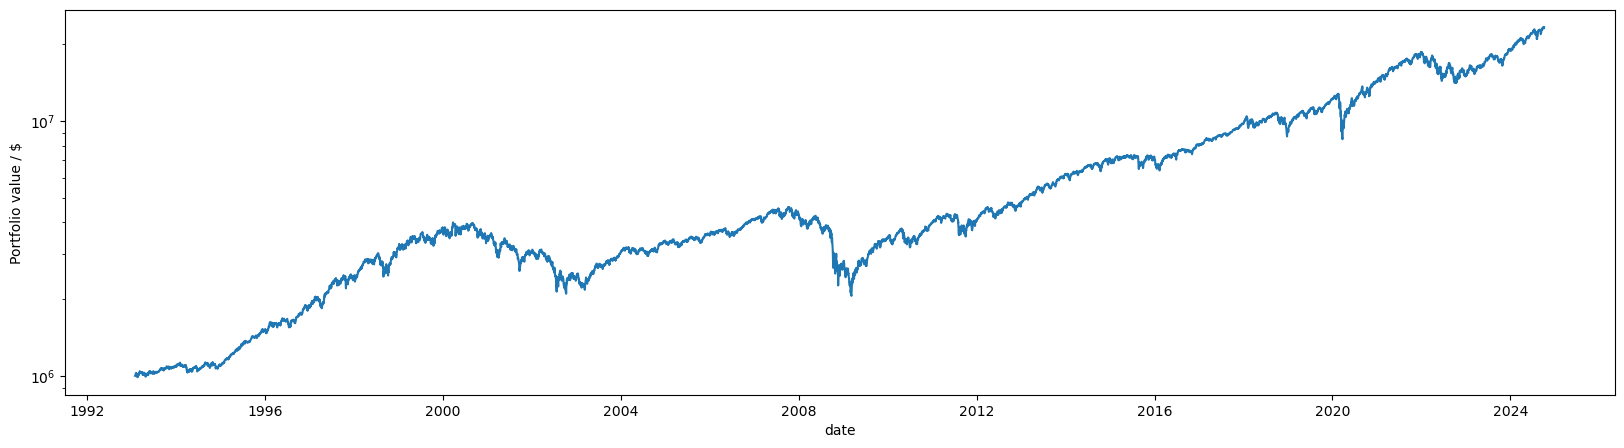

In [37]:
capital = 1e6
purchase_price = df['adjclose'].to_list()[0]
num_shares = capital // purchase_price
buy_hold_portfolio_value = np.array(df['adjclose'] * num_shares + capital - (num_shares * purchase_price))

plt.figure(figsize=(20, 5))
plt.plot(df['date'], buy_hold_portfolio_value)
plt.xlabel('date')
plt.ylabel('Portfolio value / $')
plt.yscale('log')
plt.show()

## DCA

Split capital into 120 parts and buy at the first day of every month for 10 years

In [40]:
max_buys = 120
single_buy_value = capital / max_buys

# Add a column that extracts the year and month for easy grouping
df = df.with_columns(pl.col("date").dt.strftime("%Y-%m").alias("year_month"))

# Find the first day of each month by using groupby and min() on the date column
first_days = df.group_by("year_month").agg([
    pl.col("date").min().alias("first_day_of_month")
])

# Join the original DataFrame with the `first_days` DataFrame to mark the first day
df = df.join(first_days, on="year_month", how="left")

# Create a new column "is_first_day" that checks if the date is the first day of the month
df = df.with_columns(
    (pl.col("date") == pl.col("first_day_of_month")).cast(pl.Int8).alias("is_first_day")
)

# Drop the helper columns if needed (e.g., "year_month" and "first_day_of_month")
df = df.drop(["year_month", "first_day_of_month"])
df

,date,open,high,low,close,adjclose,volume,is_first_day
i64,date,f64,f64,f64,f64,f64,i64,i8
0,1993-01-29,43.96875,43.96875,43.75,43.9375,24.608624,1003200,1
1,1993-02-01,43.96875,44.25,43.96875,44.25,24.783648,480500,1
2,1993-02-02,44.21875,44.375,44.125,44.34375,24.836161,201300,0
3,1993-02-03,44.40625,44.84375,44.375,44.8125,25.098698,529400,0
4,1993-02-04,44.96875,45.09375,44.46875,45.0,25.203714,531500,0
…,…,…,…,…,…,…,…,…
7973,2024-09-30,570.419983,574.380005,568.080017,573.76001,573.76001,63557400,0
7974,2024-10-01,573.400024,574.059998,566.0,568.619995,568.619995,72668800,1
7975,2024-10-02,567.710022,569.900024,565.27002,568.859985,568.859985,38097800,0


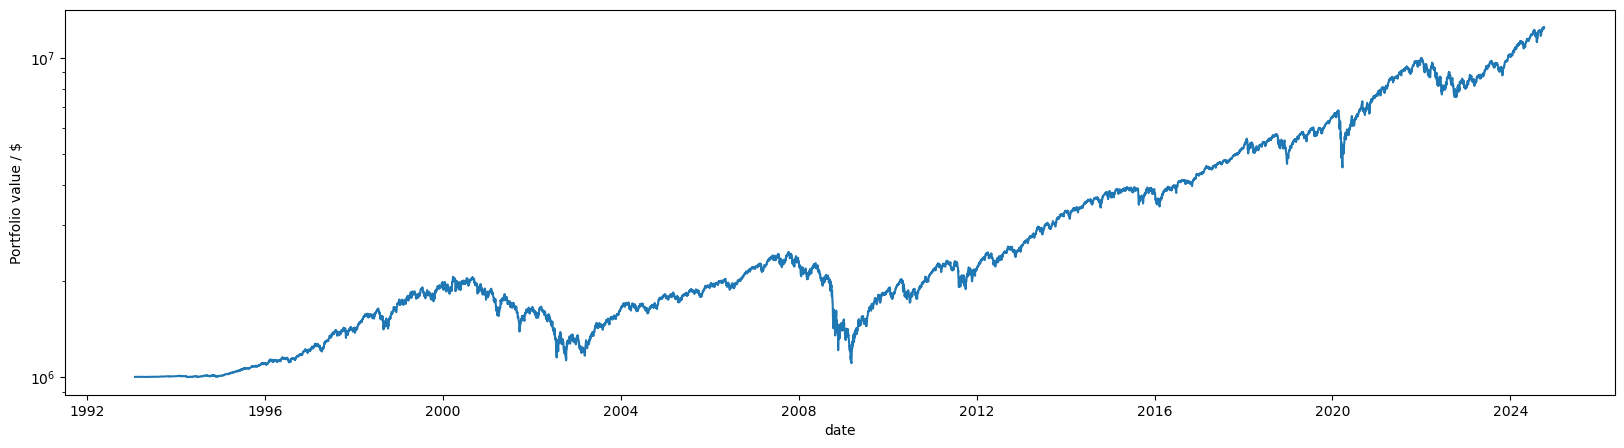

In [49]:
dca_portfolio_value = []
cash = capital
num_shares = 0
cum_num_shares = 0
num_buys = 0
for r in df.iter_rows(named=True):
    if r['is_first_day'] == 1 and num_buys < max_buys:
        
        num_shares = single_buy_value // r['adjclose']
        cash -= num_shares * r['adjclose']
        cum_num_shares += num_shares
        num_buys += 1
    
    dca_portfolio_value.append(cash + cum_num_shares * r['adjclose'])
dca_portfolio_value = np.array(dca_portfolio_value)

plt.figure(figsize=(20, 5))
plt.plot(df['date'], dca_portfolio_value)
plt.xlabel('date')
plt.ylabel('Portfolio value / $')
plt.yscale('log')
plt.show()


## Comparison

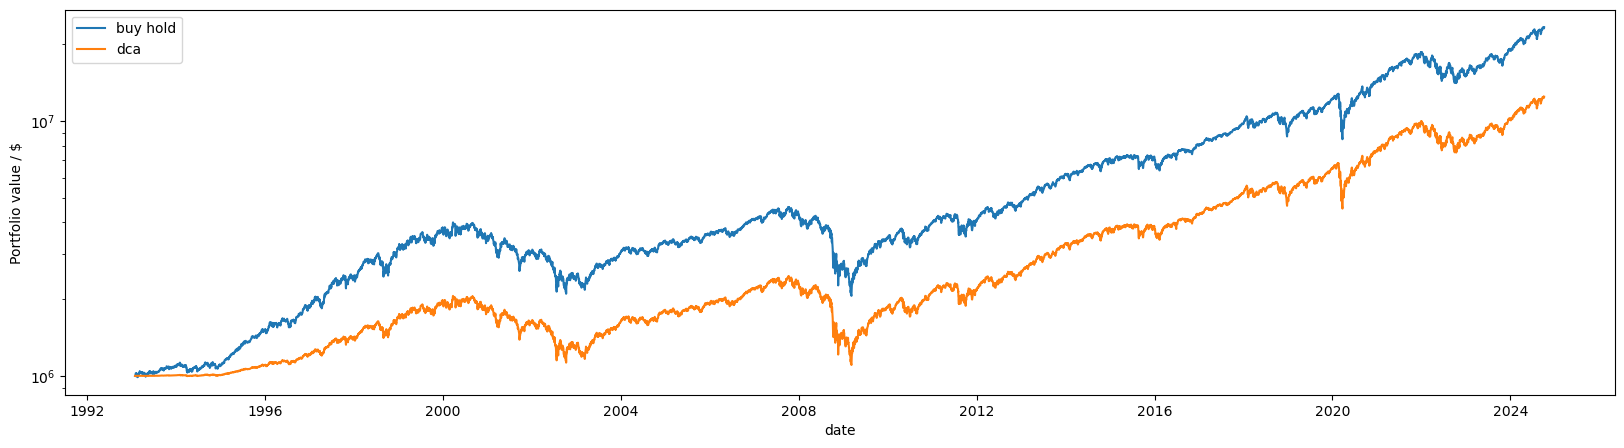

In [43]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'], buy_hold_portfolio_value, label='buy hold')
plt.plot(df['date'], dca_portfolio_value, label='dca')
plt.xlabel('date')
plt.ylabel('Portfolio value / $')
plt.yscale('log')
plt.legend()
plt.show()

### Stats

In [56]:
# Total returns
def total_returns(arr):
    return arr[-1] / arr[0]

print('Total Returns')
print(f'Buy hold    : {total_returns(buy_hold_portfolio_value) * 100 :.2f}%')
print(f'DCA         : {total_returns(dca_portfolio_value) * 100 :.2f}%')
print('---')

# CAGR
def cagr(arr):
    tr = arr[-1] / arr[0] + 1
    cagr = tr ** (252 / arr.shape[0]) - 1
    return cagr

print('CAGR')
print(f'Buy hold    : {cagr(buy_hold_portfolio_value) * 100 :.2f}%')
print(f'DCA         : {cagr(dca_portfolio_value) * 100 :.2f}%')
print('---')

# CAGR
def vol(arr):
    r = arr[1:] / arr[:-1] - 1
    vol = np.std(r)
    vol = vol * np.sqrt(252)
    return vol

print('Annualized vol')
print(f'Buy hold    : {vol(buy_hold_portfolio_value) * 100 :.2f}%')
print(f'DCA         : {vol(dca_portfolio_value) * 100 :.2f}%')
print('---')

# Sharpe
def sharpe(arr):
    cagr_ = cagr(arr)
    vol_ = vol(arr)
    return cagr_ / vol_

print('Sharpe')
print(f'Buy hold    : {sharpe(buy_hold_portfolio_value) :.2f}')
print(f'DCA         : {sharpe(dca_portfolio_value) :.2f}')
print('---')

Total Returns
Buy hold    : 2328.36%
DCA         : 1243.97%
---
CAGR
Buy hold    : 10.60%
DCA         : 8.55%
---
Annualized vol
Buy hold    : 18.64%
DCA         : 17.51%
---
Sharpe
Buy hold    : 0.57
DCA         : 0.49
---


### Drawdown

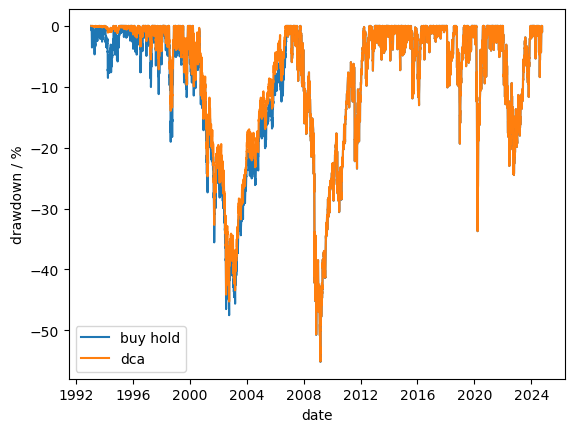

In [70]:
def drawdown(arr):
    cum_max = np.maximum.accumulate(arr)
    dd = -(cum_max - arr) / cum_max
    return dd

buy_hold_dd = drawdown(buy_hold_portfolio_value)
dca_dd = drawdown(dca_portfolio_value)

plt.plot(df['date'], buy_hold_dd * 100, label='buy hold')
plt.plot(df['date'], dca_dd * 100, label='dca')
plt.legend()
plt.xlabel('date')
plt.ylabel('drawdown / %')
plt.show()


## Conclusion

1. DCA only offers slightly less volatility with much lower returns.
2. This is because DCA only has lower market exposure at the start of the time period. Once most of the capital is already invested, the returns and volatility are similar to buy-hold, but the market exposure in the earlier years cannot be regained.
3. DCA is similarly exposed to any drawdowns at the end of the time period. This is arguably the most important time period since that is when withdrawal takes place. Therefore, DCA does not prevent any losses during the withdrawal period since it is already full invested anyway.
4. DCA is worse than buy-hold in almost all aspects and should not be used unless:
    - We have market timing knowledge, e.g. we expect a big downturn sometime soon.
    - We are forced to use DCA, e.g. our capital comes from regular income flow such as salary.